In this notebook, I try out different time series models, ARIMA, SARIMA, and FB Prophet, on my data. This is a more exploratory notebook.<br/>

Reference:
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# Table of Contents
1. [Imports](#section1)
2. [Load in Data](#section2)
3. [ARIMA Time Series](#section3)
4. [FB Prophet](#section4)

<a id='section1'></a>

### 1. Imports

In [7]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [8]:
# time series imports

# check if a time series is stationary
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

# trying out ARIMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

In [9]:
# fb prophet
import fbprophet
from fbprophet import Prophet

<a id='section2'></a>

### 2. Load in Data

In [16]:
park_df = pd.read_pickle('data/park_df.pickle')

<a id='section3'></a>

### 3. Time Series

ARIMA Model. ARIMA is short for 'Auto Regressive Integrated Moving Average'. It "explains" a time series based on the past values. It can bse used to forecast future values.<br/>
ARIMA typically models 'non-seasonal' time series.<br/>
* p (autoregression): refers to the use of past values
* d (integration): uses differences in observations from past values
* q (moving average): depicts the error of the model as a combination of previoius error terms

Here are three different types of ARIMA models:
* ARIMA (non-seasonal)
* SARIMA (seasonal ARIMA)
* SARIMAX( seasonal ARIMA with exogenous variables)

Preparation for an ARIMA model. Because an ARIMA model is a linear regression model that works best when the predictors are independent of one another and not correlated, the time series should be stationary.

<br/>
One common way is to difference it or subtract the previous value from the current value.

<br/>
A pure AR (auto-regressive) model only depends on its own lags.
y = alpha + beta1*(yt-1) + beta2*(yt-2)+...betap*(yt-p) + error

<br/>
A pure MA (moving-average) model only depends on lagged forecast error. The lagged forecast errors come from error of autoregressive models of the respective lags.
y = alpha + omega1*(et-1) + omega2*(et-2)+...omegaq(et-q) + error

<br/>
With ARIMA, the AR and MA terms are combined.

First, what is the d (order of differencing) term that can make the time series stationary?

To start off, I need to examine if my time series is stationary or not with the ADF test. The null hypothesis of this test is that the time series is non-stationary. If the p-value is less than 0.05, then I can reject the null hypothesis and infer the time series is stationary.

In [8]:
differencing_test = adfuller(park_df['num_visitors'])
print(f'ADF Statistics: {differencing_test[0]}')
print(f'p-value: {differencing_test[1]}')

ADF Statistics: -1.5746812726059634
p-value: 0.49629821847685684


Since the p-value is greater than 0.05, I cannot reject the null hypothesis.

The next step is to make the time series stationary by finding a good order of differencinng.

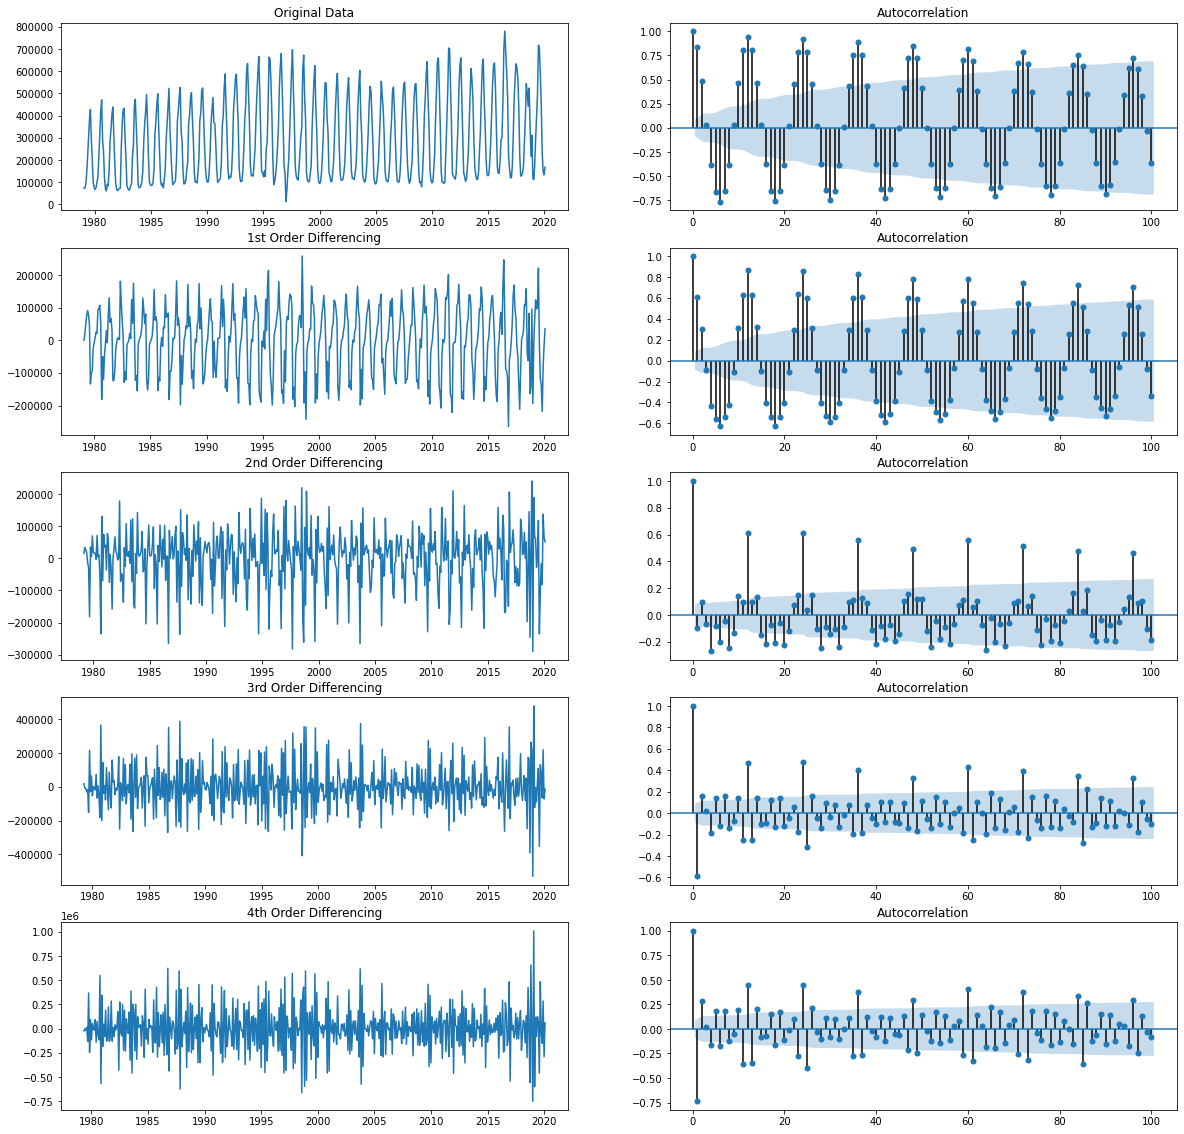

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

axes[0,0].plot(park_df['num_visitors'])
axes[0,0].set_title('Original Data')
plot_acf(park_df['num_visitors'].tolist(), lags=40, ax=axes[0,1])

axes[1,0].plot(park_df['num_visitors'].diff())
axes[1,0].set_title('1st Order Differencing')
plot_acf(park_df['num_visitors'].diff().dropna().tolist(), lags=40, ax=axes[1,1])

axes[2,0].plot(park_df['num_visitors'].diff().diff())
axes[2,0].set_title('2nd Order Differencing')
plot_acf(park_df['num_visitors'].diff().diff().dropna().tolist(), lags=40, ax=axes[2,1])

axes[3,0].plot(park_df['num_visitors'].diff().diff().diff())
axes[3,0].set_title('3rd Order Differencing')
plot_acf(park_df['num_visitors'].diff().diff().diff().dropna().tolist(), lags=40, ax=axes[3,1])

axes[4,0].plot(park_df['num_visitors'].diff().diff().diff().diff())
axes[4,0].set_title('4th Order Differencing')
plot_acf(park_df['num_visitors'].diff().diff().diff().diff().dropna().tolist(), lags=40, ax=axes[4,1]);

Looks like an optimal order of differencing may be 2nd or 3rd order because the autocorrelation plot tends to zero and doesn't show as much of a pattern.

The next step is to find the order of the p, or AR (autoregressive) term. I can do this by looking at partial autocorrelation (PACF) plots.

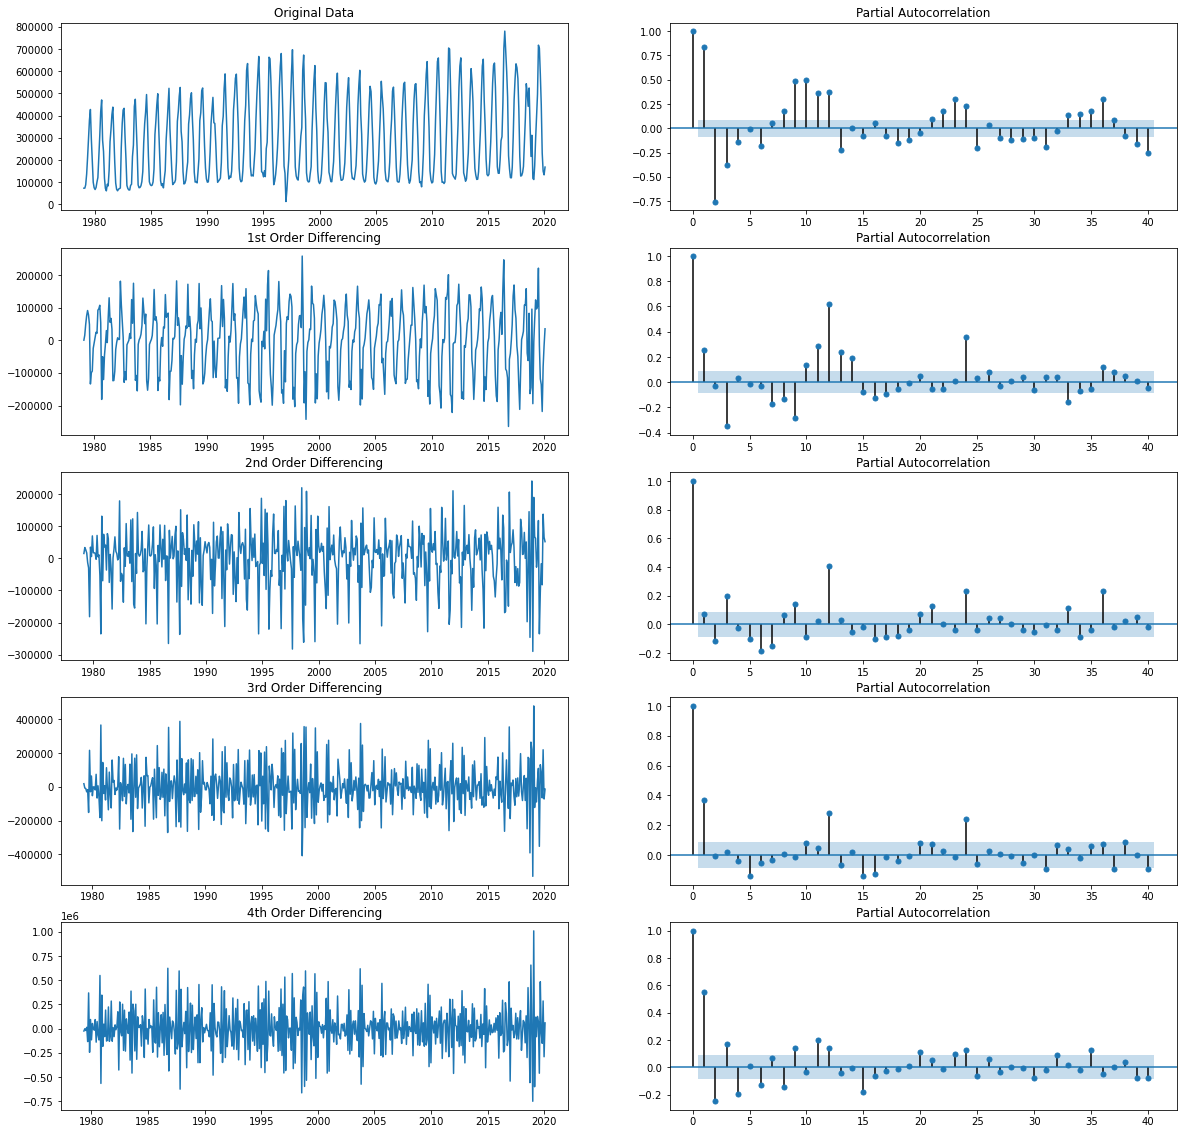

In [43]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

axes[0,0].plot(park_df['num_visitors'])
axes[0,0].set_title('Original Data')
plot_pacf(park_df['num_visitors'].tolist(), lags=40, ax=axes[0,1])

# needed to add an absolute value term?
axes[1,0].plot(park_df['num_visitors'].diff())
axes[1,0].set_title('1st Order Differencing')
plot_pacf(park_df['num_visitors'].diff().dropna().abs().tolist(), lags=40, ax=axes[1,1])

# needed to add an absolute value term?
axes[2,0].plot(park_df['num_visitors'].diff().diff())
axes[2,0].set_title('2nd Order Differencing')
plot_pacf(park_df['num_visitors'].diff().diff().dropna().abs().tolist(), lags=40, ax=axes[2,1])

# needed to add an absolute value term?
axes[3,0].plot(park_df['num_visitors'].diff().diff().diff())
axes[3,0].set_title('3rd Order Differencing')
plot_pacf(park_df['num_visitors'].diff().diff().diff().dropna().abs().tolist(), lags=40, ax=axes[3,1])

# needed to add an absolute value term?
axes[4,0].plot(park_df['num_visitors'].diff().diff().diff().diff())
axes[4,0].set_title('4th Order Differencing')
plot_pacf(park_df['num_visitors'].diff().diff().diff().diff().dropna().abs().tolist(), lags=40, ax=axes[4,1]);

The partial autocorrelation plot tends to zero around 1st and 2nd order differencing.

In [54]:
# try out an ARIMA with the p and d terms from above
model_1 = ARIMA(park_df['num_visitors'].values, order=(2, 1, 2))
model_1_fit = model_1.fit()
model_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  493
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6037.650
Method:                       css-mle   S.D. of innovations          50059.106
Date:                Wed, 02 Sep 2020   AIC                          12087.299
Time:                        17:56:15   BIC                          12112.502
Sample:                             1   HQIC                         12097.195
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        465.2073    563.700      0.825      0.409    -639.625    1570.040
ar.L1.D.y      1.7076      0.010    172.285      0.000       1.688       1.727
ar.L2.D.y     -0.9749      0.010    -99.867      0.000      -0.994      -0.956
ma.L1.D.y     -1.8271      0.016   -114.905      0.000      -1.858      -1.796
ma.L2.D.y      0.8937      0.020     44.239      0.000       0.854       0.933
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8758           -0.5086j            1.0128           -0.0837
AR.2            0.8758           +0.5086j            1.0128            0.0837
MA.1            1.0222           -0.2721j            1.0578           -0.0414
MA.2            1.0222           +0.2721j            1.0578            0.0414
-----------------------------------------------------------------------------
"""

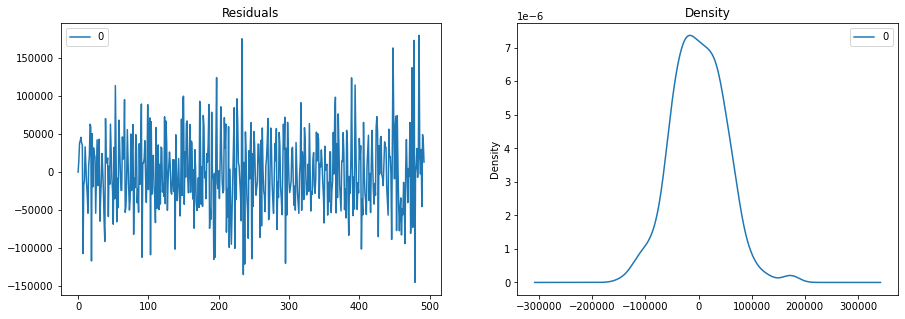

In [61]:
# plot residuals to see if they are normally distributed and don't show a pattern
residuals_1 = pd.DataFrame(model_1_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15, 5))
residuals_1.plot(title="Residuals", ax=ax[0])
residuals_1.plot(kind='kde', title='Density', ax=ax[1])

plt.show();

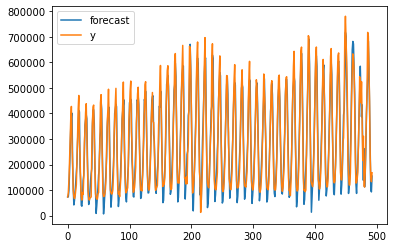

In [70]:
# plot actual vs fitted values
model_1_fit.plot_predict()
plt.show();

The model looks okay, but is there a better way to choose hyperparameters for ARIMA? Going to try using pmdarima's auto_arima function that automatically searches through various hyperparmeters to choose the one with the lowest AIC score. The AIC score quantifes the goodness of fit as well as the simplicity/parsimony of a time series model.

In [77]:
pick_arima = auto_arima(park_df['num_visitors'], start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=1, d=None, seasonal=False,
                        start_P=0, D=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
pick_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12611.000, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13989.536, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12785.988, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13611.018, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12522.860, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12521.068, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12522.658, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12524.225, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12352.001, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12757.676, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12280.116, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12278.426, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12364.960, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12275.121, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  494
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -6082.916
Date:                Wed, 02 Sep 2020   AIC                          12179.833
Time:                        18:07:58   BIC                          12209.251
Sample:                             0   HQIC                         12191.382
                                - 494                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.802e+04   1888.201     41.318      0.000    7.43e+04    8.17e+04
ar.L1          1.7292      0.003    519.816      0.000       1.723       1.736
ar.L2         -0.9973      0.003   -297.917      0.000      -1.004      -0.991
ma.L1         -1.0393      0.049    -21.151      0.000      -1.136      -0.943
ma.L2         -0.0165      0.079     -0.209      0.834      -0.171       0.138
ma.L3          0.5736      0.049     11.725      0.000       0.478       0.669
sigma2      3.641e+09   9.25e-05   3.94e+13      0.000    3.64e+09    3.64e+09
===================================================================================
Ljung-Box (Q):                     1219.13   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               1.08   Skew:                             0.07
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.58e+30. Standard errors may be unstable.
"""

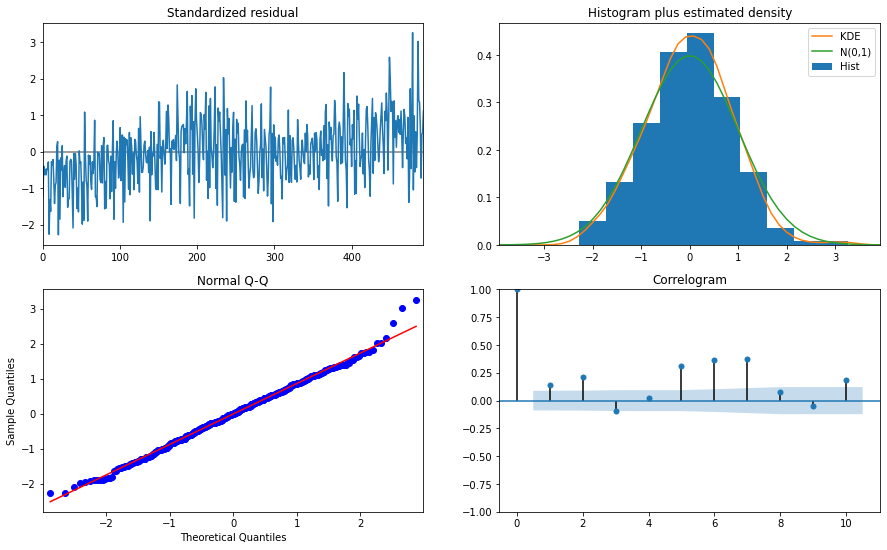

In [76]:
pick_arima.plot_diagnostics(figsize=(15,9))
plt.show()

Sarima model has 7 parameters: (p, d, q) (P, D, Q)m:
* p is the order of the AR (auto regressive piece)
* d is the integrated piece (how many times you take a difference)
* q is the order of the MA (moving average piece)

* m is the seasonal factor (number of periods within a year for the seasonality to repeat)
* P is the order of the seasonal AR piece
* D is the order of the seasonal integrated piece (how many times you take a difference)
* Q is the order of the seasonal MA piece

In [78]:
# use autoarima to find the best seasonal ARIMA because I know Yosemite visitor data is seasonal
pick_sarima = auto_arima(park_df['num_visitors'].values, start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=12, d=None, seasonal=True,
                        start_P=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
pick_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=11509.308, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11697.409, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11533.930, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11545.471, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11700.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=11612.015, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=11511.308, Time=0.61 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=11511.242, Time=0.99 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=11535.676, Time=0.39 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=11512.391, Time=2.55 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=11506.854, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11610.153, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=11508.846, Time=0.39 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=11508.777, Time=0.65 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  494
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -5749.427
Date:                              Wed, 02 Sep 2020   AIC                          11506.854
Time:                                      18:09:18   BIC                          11523.566
Sample:                                           0   HQIC                         11513.422
                                              - 494                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2675.1236    868.495      3.080      0.002     972.905    4377.342
ar.L1          0.6004      0.031     19.538      0.000       0.540       0.661
ma.S.L12      -0.6090      0.035    -17.162      0.000      -0.679      -0.539
sigma2      1.672e+09      0.000   3.97e+12      0.000    1.67e+09    1.67e+09
===================================================================================
Ljung-Box (Q):                       90.58   Jarque-Bera (JB):               232.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.12e+28. Standard errors may be unstable.
"""

In [82]:
# try forecasting for the next 36 months
n_periods = 36
fitted, confint = pick_sarima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(park_df.index[-1], periods=n_periods, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:,0], index=index_of_fc)
upper_series = pd.Series(confint[:,1], index=index_of_fc)

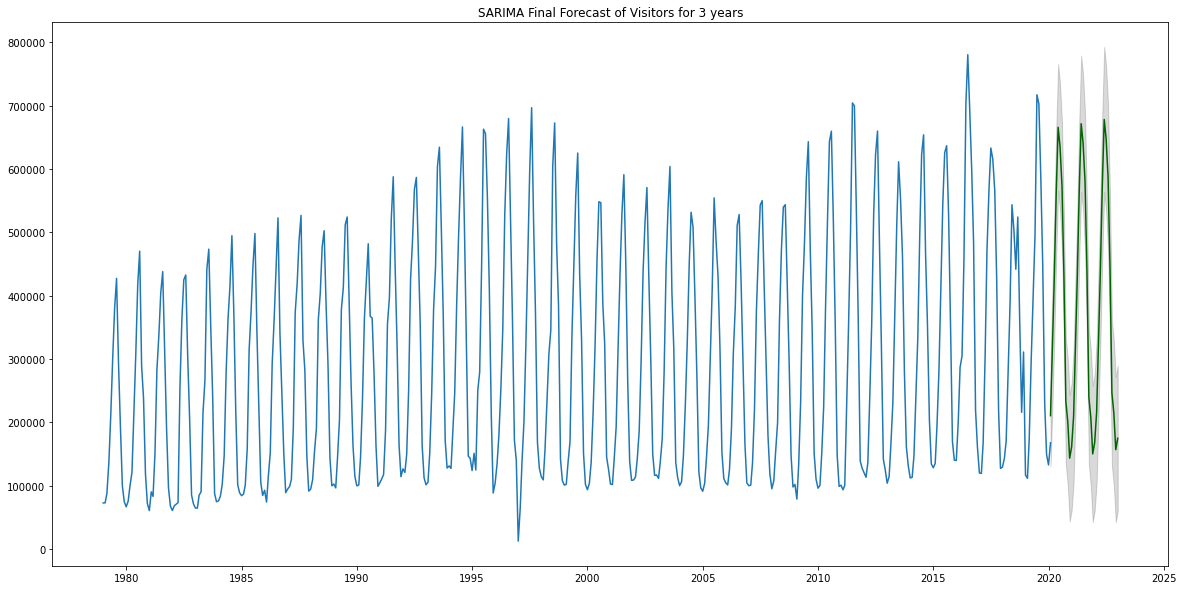

In [84]:
# show how my data performs on 2018, 2019 visitor data
plt.figure(figsize=(20,10))
plt.plot(park_df['num_visitors'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)
plt.title("SARIMA Final Forecast of Visitors for 3 years")
plt.show()

<a id='section4'></a>

### 4. FB Prophet

In [27]:
fb_model = Prophet()

In [ ]:
park_df = park_df.reset_index()
park_df.columns = ["ds", "y"]

In [28]:
fb_model.fit(park_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# monthly frequency
future = fb_model.make_future_dataframe(periods=6, freq='m')
forecast = fb_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
495,2020-03-31,295388.734041,243691.724865,349237.498118
496,2020-04-30,416576.469583,363580.218908,470424.736130
497,2020-05-31,510766.799195,461379.997617,562555.025543
498,2020-06-30,648893.201545,592686.065740,700180.882567
499,2020-07-31,672612.026398,618918.276046,723407.882202


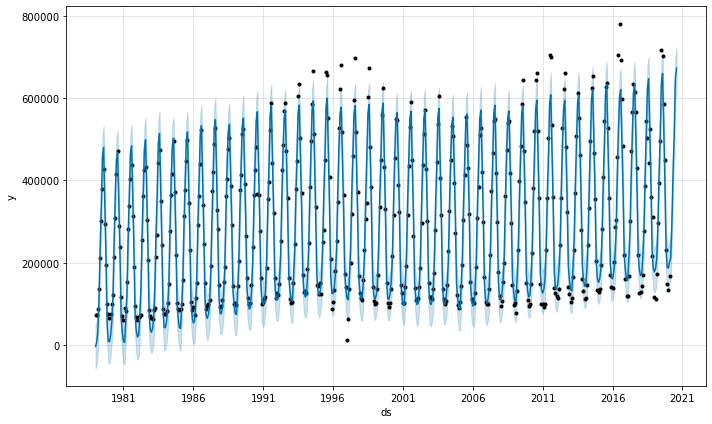

In [33]:
fig1 = fb_model.plot(forecast)

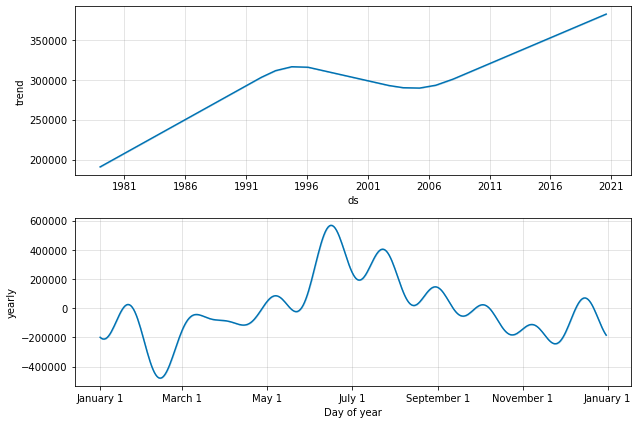

In [34]:
fig2 = fb_model.plot_components(forecast)

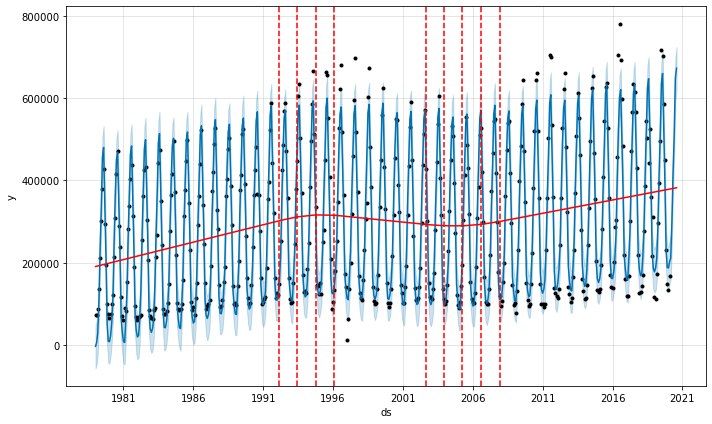

In [35]:
# looking at change points
fig3 = fb_model.plot(forecast)
a = fbprophet.plot.add_changepoints_to_plot(fig3.gca(), fb_model, forecast)

Prophet has "change point" detection. It looks at the dataset and picks our places where the trend has an elbow that's a new "trend". Overall, FB prophet is interesting. It forecasts based on an additive model and can fit with yearly, weekly, and daily seasonality.